In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
from time import time
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('punkt')
from nltk import word_tokenize
#from nltk.util import ngrams
from collections import Counter
from nltk.tokenize import RegexpTokenizer, word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import string

from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import r2_score, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
!pip install scikit-plot
from scikitplot.metrics import plot_confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data

In [25]:
df_reviews2 = pd.read_csv('03_df_reviews_ret.csv')
df_reviews2['datecreated'] = pd.to_datetime(df_reviews2['datecreated'])

In [26]:
df_reviews2.head()

,ticker,group,datecreated,replaced_message,pricet,pricew,ret
0,MBGYY,Mercedes-Benz,2021-12-15,"momoney232 said:Hello, I am trying to get the ...",22.516418,22.037542,-0.021268
1,MBGYY,Mercedes-Benz,2021-12-15,Thank you for the reply. Can you let me know w...,22.516418,22.037542,-0.021268
2,MBGYY,Mercedes-Benz,2021-12-15,.00150 MF,22.516418,22.037542,-0.021268
3,MBGYY,Mercedes-Benz,2021-12-18,What about the eqs 580? Do you have rates for ...,21.706011,22.083588,0.017395
4,MBGYY,Mercedes-Benz,2021-12-18,We do.Ask your question.,21.706011,22.083588,0.017395


In [27]:
df_reviews2.sort_values(by='datecreated').rename({'replaced_message':'comment'}, axis=1).iloc[:,:-2]

,ticker,group,datecreated,comment,pricet
33469,TM,Toyota,2020-01-02,Are the January numbers available yet?2020 XLE...,142.240005
97677,BMWYY,BMW,2020-01-02,Current BMW programs run through Sunday,23.974298
97676,BMWYY,BMW,2020-01-02,Happy New Year and Thanks in advance! Are the ...,23.974298
72315,FUJHY,Subaru,2020-01-02,Greetings and happy New year!Can you please pr...,12.450000
72316,FUJHY,Subaru,2020-01-02,36/15.00140 and 58%,12.450000
...,...,...,...,...,...
11019,MZDAY,Mazda,2023-04-08,alfred33 said: Michaell said: alfred33 said:Ma...,4.270000
11018,MZDAY,Mazda,2023-04-08,"Hi,Could you please provide MF and residual fo...",4.270000
11017,MZDAY,Mazda,2023-04-08,alfred33 said:May I please have MF and residu...,4.270000
9907,BMWYY,MINI,2023-04-08,I'm looking for March lease info for the follo...,35.900002


## Tokenize

In [86]:
# Removing punctuation
tokenizer = RegexpTokenizer(r'\w+') #removes punctuation, keeps only words
# Stopwords
stop_words = set(stopwords.words('english'))

In [87]:
# Function tokenize and count
def counts(x): #count frequencies
  return Counter([t for t in tokenizer.tokenize((x.lower())) if not t in stop_words])

# Applying counts
c_w_counts = df_reviews2['replaced_message'].astype(str).apply(counts)
c_w_counts

0         {'momoney232': 1, 'said': 1, 'hello': 1, 'tryi...
1         {'thank': 1, 'reply': 1, 'let': 1, 'know': 1, ...
2                                     {'00150': 1, 'mf': 1}
3                          {'eqs': 1, '580': 1, 'rates': 1}
4                                 {'ask': 1, 'question': 1}
                                ...                        
108969                                 {'4x2': 1, '4x4': 1}
108970    {'please': 1, 'get': 1, 'numbers': 1, '4runner...
108971    {'00202': 1, 'mf69': 1, '71': 1, 'residual': 1...
108972    {'hi': 1, 'tell': 1, 'mf': 1, 'residual': 1, '...
108973    {'lease': 1, 'programs': 1, '2020': 1, 'models...
Name: replaced_message, Length: 108974, dtype: object

In [ ]:
# # counter of all words
# c_w_all = c_w_counts.sum()
# # dict of all words
# s_w_all = c_w_all.keys()

## Train/Test Split - 75%/25%

In [28]:
# Train size
train_size = 0.75
n_train_size = int(train_size*len(df_reviews2))

In [30]:
# Indices
np.random.seed(2022)
idx = np.random.permutation(len(df_reviews2))

train_idx = idx[:n_train_size]
test_idx = idx[n_train_size:]

## Feature Vectorizing

In [31]:
# Lowercase
def convert_lowercase(x):
    return str(x).lower()

# Remove URL
def remove_url(x):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', x)

# Remove Punctuation
exclude = string.punctuation
def remove_punc(x):
    return x.translate(str.maketrans('', '', exclude))

# Remove Stopwords
def remove_stopwords(x):
    new_list = []
    words = word_tokenize(x)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

# Formatting
df_x = df_reviews2[['replaced_message']].rename(columns={'replaced_message':'Message'})
df_x['Message'] = df_x['Message'].apply(convert_lowercase)
df_x['Message'] = df_x['Message'].apply(remove_url)
df_x['Message'] = df_x['Message'].apply(remove_punc)
df_x['Message'] = df_x['Message'].apply(remove_stopwords)
df_x

,Message
0,momoney232 saidhello trying get rv mf eqs 450 ...
1,thank reply let know standard mf model
2,00150 mf
3,eqs 580 rates
4,doask question
...,...
108969,4x2 4x4
108970,please get numbers 4runner 4x4 sr5 36 months 1...
108971,00202 mf6971 residual sr5or
108972,hi tell mf residual 4runner limited zip 11230 ...


In [34]:
# Tfidf Vectorizing
X = df_x['Message']
y = df_reviews2['ret']

tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
X = tfidf.fit_transform(X).toarray()
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [58]:
vocab = list(tfidf.get_feature_names_out())

In [68]:
df_reviews2.loc[7,'replaced_message']

'Does anyone know of a dealer selling 2022 EQS 580 at a reasonable price? huge mark ups out west '

In [67]:
message = 7
for i in range(2500):
  if X[message][i]!=0:
    print(X[message][i], vocab[i])

0.19697262313957428 2022
0.3757526262150593 580
0.29621272315238484 anyone
0.18001437480719082 dealer
0.34748322262922665 eqs
0.40311836423765 huge
0.22198813001966783 know
0.3532306642316167 mark
0.22295017616457785 price
0.34465981790889294 reasonable
0.2721539791754825 selling


In [69]:
# Train/Test split
X_train = X[train_idx]
y_train = y[train_idx]
X_test = X[test_idx]
y_test = y[test_idx]

# Linear Regression

In [ ]:
# Logistic Regression
t0 = time()
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Time: {:.2f} min'.format((time()-t0)/60))

Time: 1.29 min


In [ ]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print('Train: - R2: {:.2%}'.format(r2_score(y_train, y_train_pred)) )
print('Test : - R2: {:.2%}'.format(r2_score(y_test, y_test_pred)) )

Train: - R2: 5.81%
Test : - R2: -0.40%


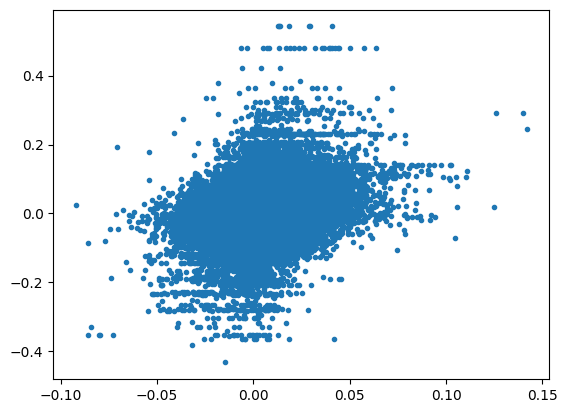

In [ ]:
plt.plot(y_train_pred,y_train,'.');

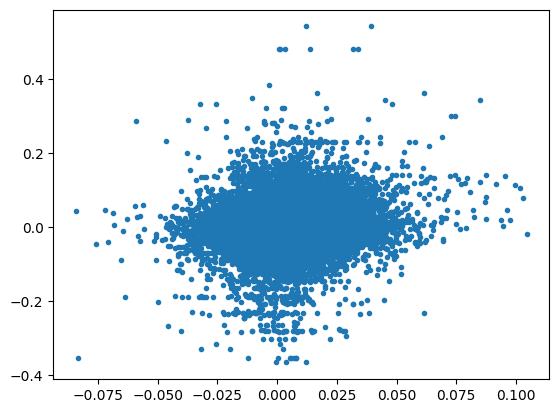

In [ ]:
plt.plot(y_test_pred,y_test,'.');

In [ ]:
y_pred = lr.predict(X)
df_reviews2['y_pred'] = y_pred
#df_reviews2['groups'] = df_reviews2.groupby('datecreated')['y_pred'].transform(lambda x: pd.qcut(x, 5, labels=[1,2,3,4,5]))
df_reviews2['groups'] = pd.qcut(df_reviews2['y_pred'], 5, labels=[1,2,3,4,5])

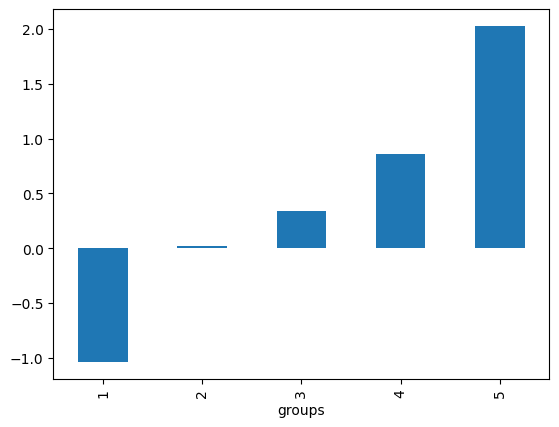

In [ ]:
(df_reviews2.groupby('groups')['ret'].mean()*100).plot(kind='bar');

In [ ]:
df_train = df_reviews2.loc[train_idx].copy()
df_test = df_reviews2.loc[test_idx].copy()

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

df_train['y_pred'] = y_train_pred
df_test['y_pred'] = y_test_pred

df_train['groups'] = pd.qcut(df_train['y_pred'], 5, labels=[1,2,3,4,5])
df_test['groups'] = pd.qcut(df_test['y_pred'], 5, labels=[1,2,3,4,5])

In [ ]:
pd.DataFrame({'Train':df_train.groupby('groups')['ret'].mean()*100,'Test':df_test.groupby('groups')['ret'].mean()*100})

,Train,Test
groups,,
1,-1.263817,-0.364238
2,-0.018153,0.142819
3,0.361502,0.263803
4,0.937616,0.613235
5,2.281494,1.270673


In [ ]:
print('Train: Gap - {:.3f}'.format((df_train.groupby('groups')['ret'].mean()[5]-df_train.groupby('groups')['ret'].mean()[1])*100))
print('Test : Gap - {:.3f}'.format((df_test.groupby('groups')['ret'].mean()[5]-df_test.groupby('groups')['ret'].mean()[1])*100))

Train: Gap - 3.545
Test : Gap - 1.635


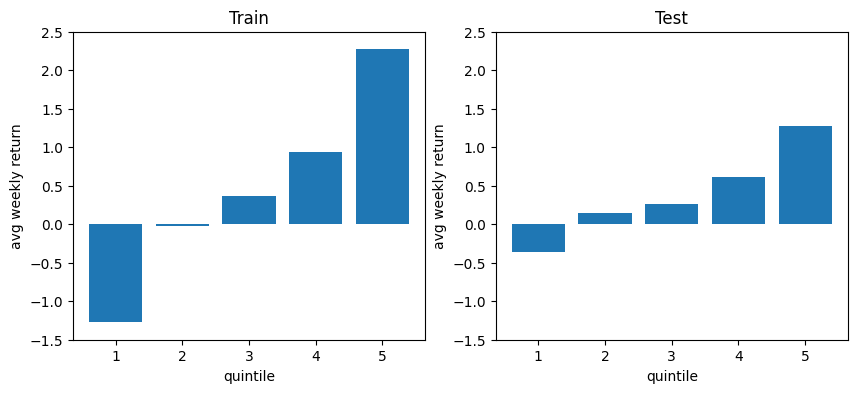

In [ ]:
yg_train_ret = df_train.groupby('groups')['ret'].mean()*100
yg_test_ret = df_test.groupby('groups')['ret'].mean()*100

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.bar([*range(1,6)],yg_train_ret)
ax1.set_title('Train')
ax1.set_xlabel('quintile')
ax1.set_ylabel('avg weekly return')
ax1.set_ylim(-1.5,2.5)

ax2.bar([*range(1,6)],yg_test_ret)
ax2.set_title('Test')
ax2.set_xlabel('quintile')
ax2.set_ylabel('avg weekly return')
ax2.set_ylim(-1.5,2.5)
plt.show()

## Lasso

In [72]:
# Lasso CV with Normalized X train
t0 = time()
modelcv = make_pipeline(StandardScaler(), LassoCV(cv=10)).fit(X_train, y_train)
print('Time: {:.2f} min'.format((time()-t0)/60))

# Optimal Lambda
bestlambda = modelcv['lassocv'].alpha_
print('Optimal : {}'.format(bestlambda))

Time: 5.78 min
Optimal : 0.00024056991625901155


In [73]:
t0 = time()
model = make_pipeline(StandardScaler(), Lasso(alpha=bestlambda)).fit(X, y)
print('Time: {:.2f} min'.format((time()-t0)/60))

Time: 0.31 min


In [74]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('Train: - R2: {:.2%}'.format(r2_score(y_train, y_train_pred)) )
print('Test : - R2: {:.2%}'.format(r2_score(y_test, y_test_pred)) )

Train: - R2: 2.87%
Test : - R2: 3.01%


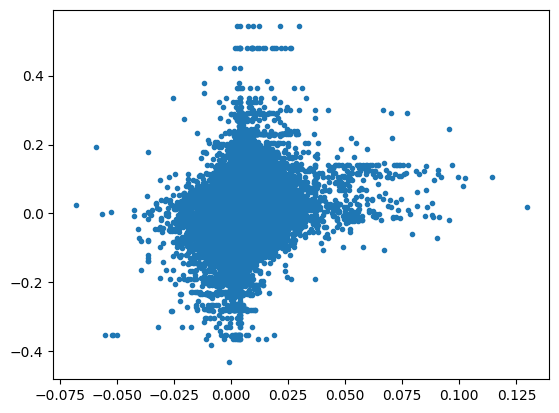

In [ ]:
plt.plot(y_train_pred,y_train,'.');

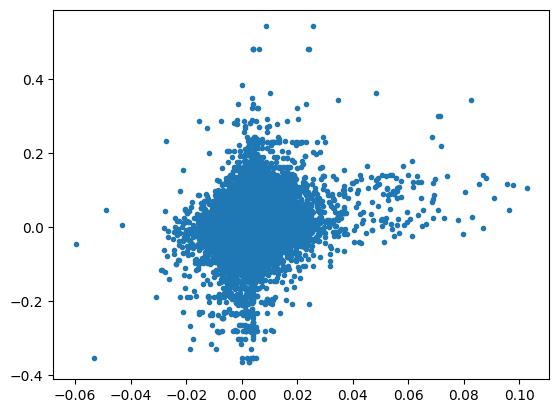

In [ ]:
plt.plot(y_test_pred,y_test,'.');

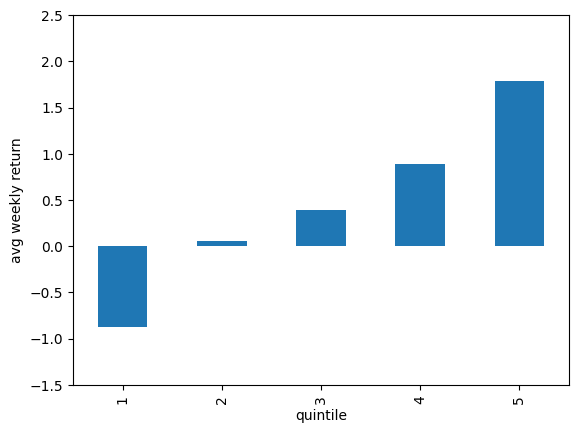

In [75]:
# Groups Total
y_pred = model.predict(X)
df_reviews2['y_pred'] = y_pred
df_reviews2['groups'] = pd.qcut(df_reviews2['y_pred'], 5, labels=[1,2,3,4,5])

(df_reviews2.groupby('groups')['ret'].mean()*100).plot(kind='bar')
plt.xlabel('quintile')
plt.ylabel('avg weekly return')
plt.ylim(-1.5,2.5);

In [76]:
df_train = df_reviews2.loc[train_idx].copy()
df_test = df_reviews2.loc[test_idx].copy()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

df_train['y_pred'] = y_train_pred
df_test['y_pred'] = y_test_pred

df_train['groups'] = pd.qcut(df_train['y_pred'], 5, labels=[1,2,3,4,5])
df_test['groups'] = pd.qcut(df_test['y_pred'], 5, labels=[1,2,3,4,5])

In [ ]:
pd.DataFrame({'Train':df_train.groupby('groups')['ret'].mean()*100,'Test':df_test.groupby('groups')['ret'].mean()*100})

,Train,Test
groups,,
1,-0.856457,-0.941295
2,0.066070,0.021488
3,0.422702,0.354406
4,0.882447,0.933662
5,1.833478,1.639625


In [ ]:
print('Train: Gap - {:.3f}'.format((df_train.groupby('groups')['ret'].mean()[5]-df_train.groupby('groups')['ret'].mean()[1])*100))
print('Test : Gap - {:.3f}'.format((df_test.groupby('groups')['ret'].mean()[5]-df_test.groupby('groups')['ret'].mean()[1])*100))

Train: Gap - 2.690
Test : Gap - 2.581


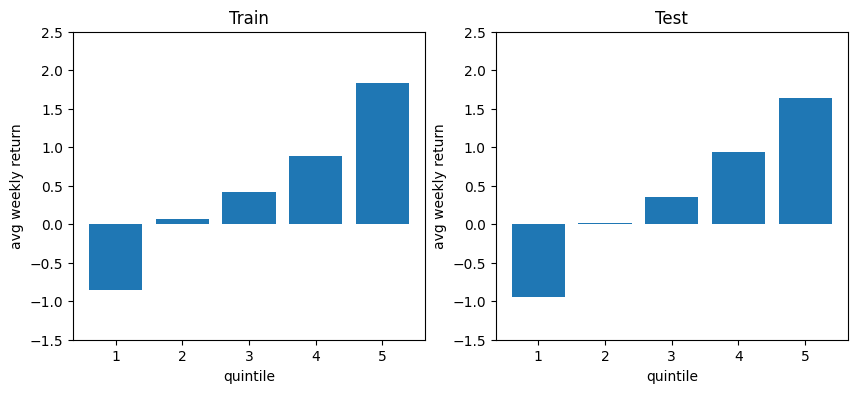

In [ ]:
yg_train_ret = df_train.groupby('groups')['ret'].mean()*100
yg_test_ret = df_test.groupby('groups')['ret'].mean()*100

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.bar([*range(1,6)],yg_train_ret)
ax1.set_title('Train')
ax1.set_xlabel('quintile')
ax1.set_ylabel('avg weekly return')
ax1.set_ylim(-1.5,2.5)

ax2.bar([*range(1,6)],yg_test_ret)
ax2.set_title('Test')
ax2.set_xlabel('quintile')
ax2.set_ylabel('avg weekly return')
ax2.set_ylim(-1.5,2.5)
plt.show()

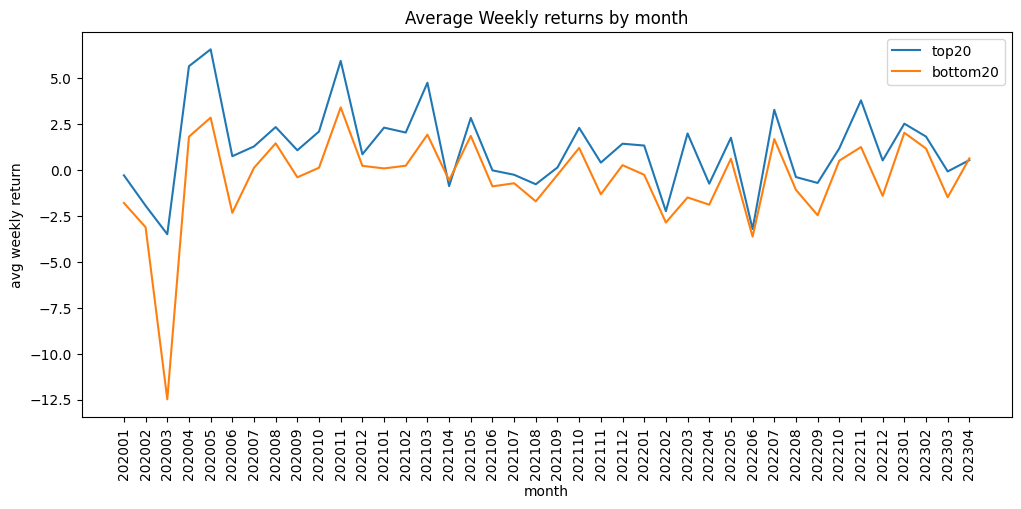

In [83]:
s_month_5 = df_reviews2.groupby([df_reviews2['datecreated'].dt.strftime('%Y%m'),'groups'])[['ret']].mean().unstack().droplevel(0,axis=1)[5]*100
s_month_1 = df_reviews2.groupby([df_reviews2['datecreated'].dt.strftime('%Y%m'),'groups'])[['ret']].mean().unstack().droplevel(0,axis=1)[1]*100

# Plot
fig = plt.figure(figsize=(12,5))
plt.plot(s_month_5, label='top20')
plt.plot(s_month_1, label='bottom20')
plt.title('Average Weekly returns by month')
plt.xlabel('month')
plt.ylabel('avg weekly return')
plt.xticks(rotation=90)
plt.legend();


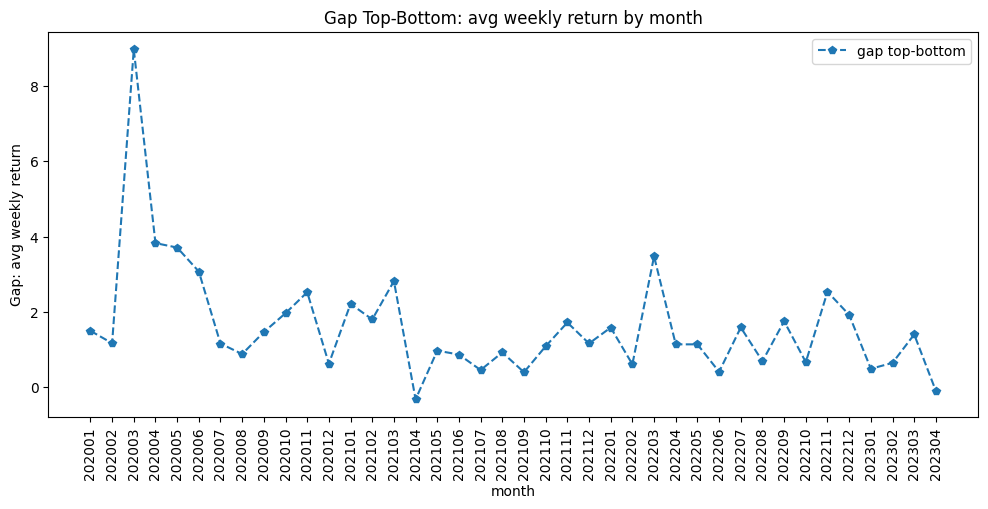

In [ ]:
# Plot
fig = plt.figure(figsize=(12,5))
plt.plot(s_month_5-s_month_1, 'p--', label='gap top-bottom')
plt.title('Gap Top-Bottom: avg weekly return by month')
plt.xlabel('month')
plt.ylabel('Gap: avg weekly return')
plt.xticks(rotation=90)
plt.legend();

### Words

In [84]:
# Indexes
idx_q5 = df_reviews2[df_reviews2['groups']==5].index.tolist()
idx_q1 = df_reviews2[df_reviews2['groups']==1].index.tolist()

In [88]:
t0 = time()
c_w_counts_q5 = c_w_counts[idx_q5].sum()
print('Time: {:.2f} min'.format((time()-t0)/60))

In [ ]:
t0 = time()
c_w_counts_q1 = c_w_counts[idx_q1].sum()
print('Time: {:.2f} min'.format((time()-t0)/60))

Time: 2.44 min


In [ ]:
c_w_counts_q5.most_common(10)

[('mf', 15905),
 ('36', 12904),
 ('incentives', 9628),
 ('lease', 9358),
 ('2021', 8431),
 ('residual', 8199),
 ('rv', 6904),
 ('please', 6048),
 ('said', 5785),
 ('zip', 5779)]

In [ ]:
c_w_counts_q1.most_common(10)

[('mf', 17324),
 ('36', 13150),
 ('incentives', 10841),
 ('residual', 8421),
 ('lease', 7422),
 ('rv', 7109),
 ('zip', 6709),
 ('please', 6300),
 ('2020', 5482),
 ('2022', 4870)]

In [89]:
df_tic_m = df_reviews2.groupby([df_reviews2['datecreated'].dt.strftime('%Y%m'),'ticker'])[['ret','y_pred','replaced_message']]\
                      .agg({'ret':'mean','y_pred':'mean','replaced_message':'count'}).unstack().rename({'replaced_message':'counts'}, axis=1)

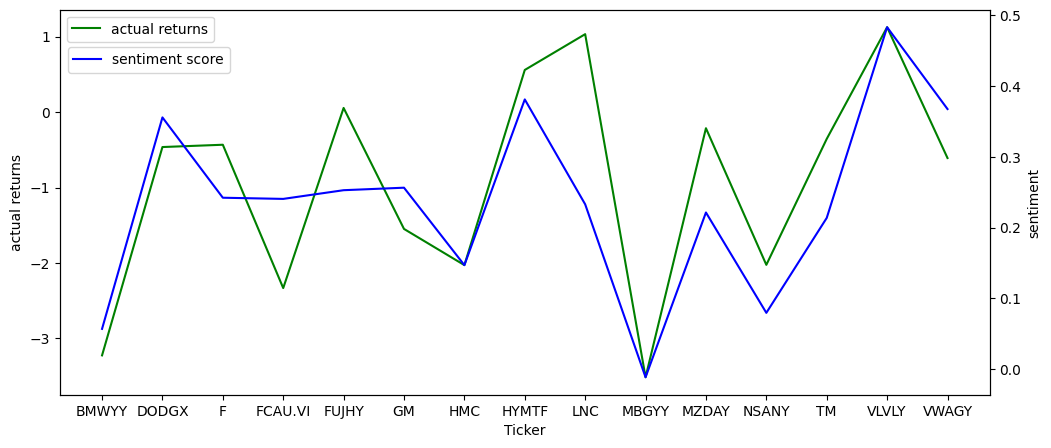

In [95]:
s_ret  = df_tic_m.loc['202001']['ret'].dropna()*100           # 202001, 202011, 202110 # 202101, 202203
s_pred = df_tic_m.loc['202001']['y_pred'].dropna()*100

fig, ax1 = plt.subplots(figsize=(12,5))
ax2 = ax1.twinx()
ax1.plot(s_ret, 'g-', label='actual returns')
ax2.plot(s_pred, 'b-', label='sentiment score')
ax1.set_xlabel('Ticker')
ax1.set_ylabel('actual returns')
ax2.set_ylabel('sentiment')
ax1.legend()
ax2.legend(bbox_to_anchor =(.19, 0.92))
plt.show()

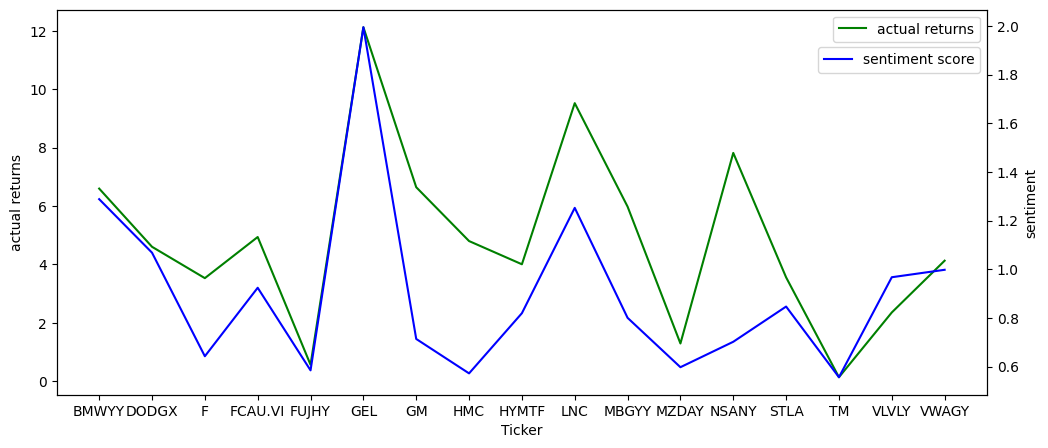

In [ ]:
s_ret  = df_tic_m.loc['202011']['ret'].dropna()*100           # 202001, 202011, 202110 # 202101, 202203
s_pred = df_tic_m.loc['202011']['y_pred'].dropna()*100

fig, ax1 = plt.subplots(figsize=(12,5))
ax2 = ax1.twinx()
ax1.plot(s_ret, 'g-', label='actual returns')
ax2.plot(s_pred, 'b-', label='sentiment score')
ax1.set_xlabel('Ticker')
ax1.set_ylabel('actual returns')
ax2.set_ylabel('sentiment')
ax1.legend()
ax2.legend(bbox_to_anchor =(1, 0.92))
plt.show()

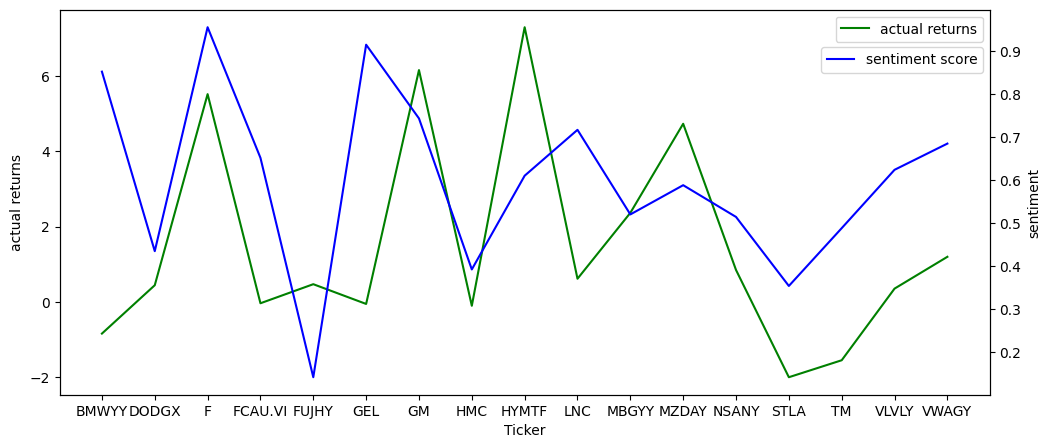

In [ ]:
s_ret  = df_tic_m.loc['202101']['ret'].dropna()*100           # 202001, 202011, 202110 # 202101, 202203
s_pred = df_tic_m.loc['202101']['y_pred'].dropna()*100

fig, ax1 = plt.subplots(figsize=(12,5))
ax2 = ax1.twinx()
ax1.plot(s_ret, 'g-', label='actual returns')
ax2.plot(s_pred, 'b-', label='sentiment score')
ax1.set_xlabel('Ticker')
ax1.set_ylabel('actual returns')
ax2.set_ylabel('sentiment')
ax1.legend()
ax2.legend(bbox_to_anchor =(1, 0.92))
plt.show()

In [96]:
sm_bottom = np.zeros(len(df_tic_m.index))
sm_top = np.zeros(len(df_tic_m.index))
g = 0
for i,m in enumerate(df_tic_m.index):
  idx_order = np.argsort(df_tic_m.loc[m]['y_pred'].dropna())
  n2 = int(len(idx_order)/2)
  df_tic_m.loc[m]['y_pred'].dropna()[idx_order]

  aux_ret1 = df_tic_m.loc[m]['ret'].dropna()[idx_order][:n2]
  aux_cnt1 = df_tic_m.loc[m]['counts'].dropna()[idx_order][:n2]
  aux_ret2 = df_tic_m.loc[m]['ret'].dropna()[idx_order][n2:]
  aux_cnt2 = df_tic_m.loc[m]['counts'].dropna()[idx_order][n2:]
  sm_bottom[i] = sum(aux_ret1*aux_cnt1)/sum(aux_cnt1)
  sm_top[i] = sum(aux_ret2*aux_cnt2)/sum(aux_cnt2)
  if sm_top[i]>sm_bottom[i]: g+=1
  print('Month: {} - Bottom: {:>8.2%} - Top: {:>8.2%}'.format(m,sum(aux_ret1*aux_cnt1)/sum(aux_cnt1),sum(aux_ret2*aux_cnt2)/sum(aux_cnt2)))
print(len(df_tic_m.index), g, round(100*g/len(df_tic_m.index),3))

Month: 202001 - Bottom:   -2.23% - Top:   -0.52%
Month: 202002 - Bottom:   -2.92% - Top:   -2.52%
Month: 202003 - Bottom:  -11.30% - Top:   -9.59%
Month: 202004 - Bottom:    3.79% - Top:    3.31%
Month: 202005 - Bottom:    3.48% - Top:    5.13%
Month: 202006 - Bottom:   -1.73% - Top:   -0.88%
Month: 202007 - Bottom:    0.68% - Top:    0.70%
Month: 202008 - Bottom:    1.75% - Top:    2.23%
Month: 202009 - Bottom:   -0.41% - Top:    0.70%
Month: 202010 - Bottom:    0.73% - Top:    1.41%
Month: 202011 - Bottom:    3.94% - Top:    5.11%
Month: 202012 - Bottom:    1.17% - Top:    0.34%
Month: 202101 - Bottom:    0.41% - Top:    2.17%
Month: 202102 - Bottom:    0.57% - Top:    2.23%
Month: 202103 - Bottom:    1.10% - Top:    4.81%
Month: 202104 - Bottom:   -0.19% - Top:   -1.41%
Month: 202105 - Bottom:    1.43% - Top:    3.19%
Month: 202106 - Bottom:   -0.08% - Top:   -1.08%
Month: 202107 - Bottom:   -0.57% - Top:   -0.37%
Month: 202108 - Bottom:   -1.29% - Top:   -0.98%
Month: 202109 - Bott

In [97]:
s_idx = df_reviews2.groupby([df_reviews2['datecreated'].dt.strftime('%Y%m'),'groups'])[['ret']].mean().unstack().index

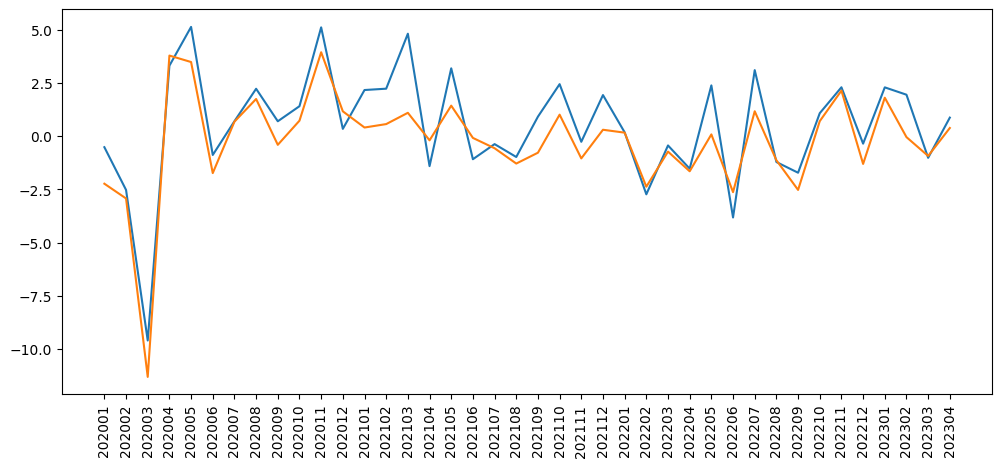

In [99]:
fig = plt.figure(figsize=(12,5))
plt.plot(s_idx,sm_top*100, label = 'Top-Sentiment')
plt.plot(s_idx,sm_bottom*100, label = 'Bottom-Sentiment')
plt.xticks(rotation=90);

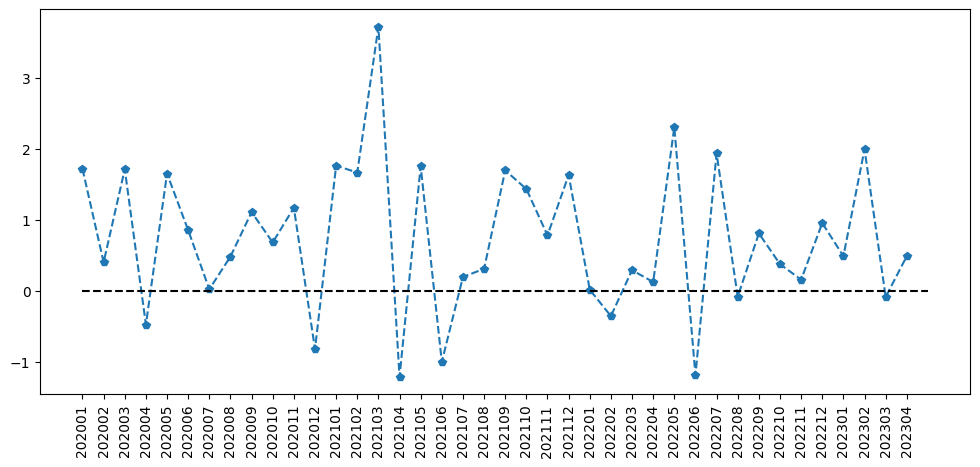

In [100]:
fig = plt.figure(figsize=(12,5))
plt.plot(s_idx,sm_top*100-sm_bottom*100, 'p--', label = 'Gap Top-Bottom')
plt.plot([0,40],[0,0], 'k--')
plt.xticks(rotation=90);

## Random Forest

In [ ]:
# Logistic Regression
t0 = time()
rf = RandomForestRegressor(max_depth=15)
rf.fit(X_train, y_train)
print('Time: {:.2f} min'.format((time()-t0)/60))

Time: 57.68 min


In [ ]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print('Train: - R2: {:.2%}'.format(r2_score(y_train, y_train_pred)) )
print('Test : - R2: {:.2%}'.format(r2_score(y_test, y_test_pred)) )

Train: - R2: 4.66%
Test : - R2: 0.85%


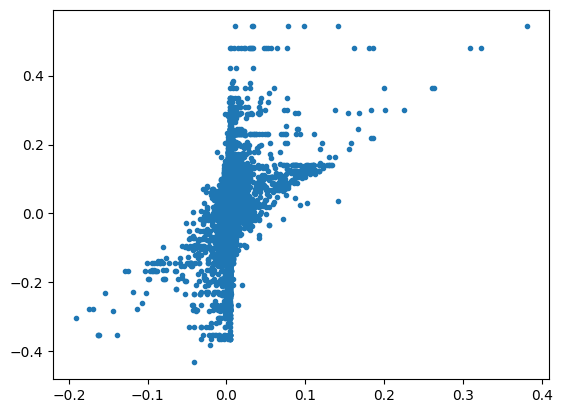

In [ ]:
plt.plot(y_train_pred,y_train,'.');

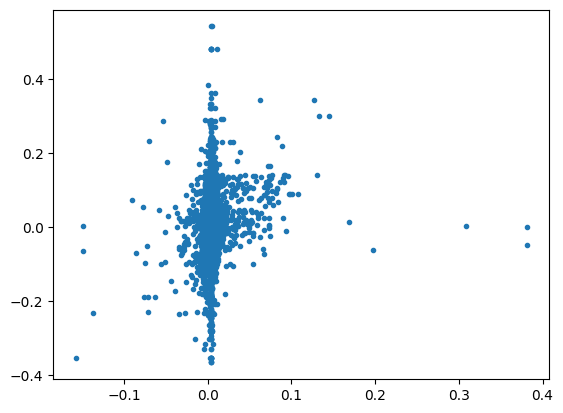

In [ ]:
plt.plot(y_test_pred,y_test,'.');

In [ ]:
df_train = df_reviews2.loc[train_idx].copy()
df_test = df_reviews2.loc[test_idx].copy()

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

df_train['y_pred'] = y_train_pred
df_test['y_pred'] = y_test_pred

df_train['groups'] = pd.qcut(df_train['y_pred'], 5, labels=[1,2,3,4,5])
df_test['groups'] = pd.qcut(df_test['y_pred'], 5, labels=[1,2,3,4,5])

ValueError: ignored

In [ ]:
pd.DataFrame({'Train':df_train.groupby('groups')['ret'].mean()*100,'Test':df_test.groupby('groups')['ret'].mean()*100})

In [ ]:
print('Train: Gap - {:.3f}'.format((df_train.groupby('groups')['ret'].mean()[5]-df_train.groupby('groups')['ret'].mean()[1])*100))
print('Test : Gap - {:.3f}'.format((df_test.groupby('groups')['ret'].mean()[5]-df_test.groupby('groups')['ret'].mean()[1])*100))

In [ ]:
yg_train_ret = df_train.groupby('groups')['ret'].mean()*100
yg_test_ret = df_test.groupby('groups')['ret'].mean()*100

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.bar([*range(1,6)],yg_train_ret)
ax1.set_title('Train')
ax1.set_xlabel('quintile')
ax1.set_ylabel('avg weekly return')
ax1.set_ylim(-1.5,2.5)

ax2.bar([*range(1,6)],yg_test_ret)
ax2.set_title('Test')
ax2.set_xlabel('quintile')
ax2.set_ylabel('avg weekly return')
ax2.set_ylim(-1.5,2.5)
plt.show()

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
training_sentences = df_x['Message'][train_idx].tolist()
testing_sentences = df_x['Message'][test_idx].tolist()

In [ ]:
training_labels_final = np.array(y[train_idx])
testing_labels_final = np.array(y[test_idx])

In [ ]:
# Parameters
vocab_size = 10000
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [ ]:
# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [ ]:
import tf.keras.backend as K

def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Set the training parameters
model_lstm.compile(loss='mean_squared_error',optimizer='sgd',metrics=[r2])

# Print the model summary
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 6)                 390       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [ ]:
NUM_EPOCHS = 3
BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(padded, 
                              training_labels_final, 
                              batch_size=BATCH_SIZE, 
                              epochs=NUM_EPOCHS, 
                              validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
639/639 [==============================] - 110s 165ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 2/10
639/639 [==============================] - 105s 165ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 3/10
639/639 [==============================] - 109s 171ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 4/10
639/639 [==============================] - 106s 167ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 5/10
639/639 [==============================] - 115s 180ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 6/10
639/639 [==============================] - 110s 173ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 7/10
639/639 [==============================] - 109s 171ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 8/10
639/639 [============================

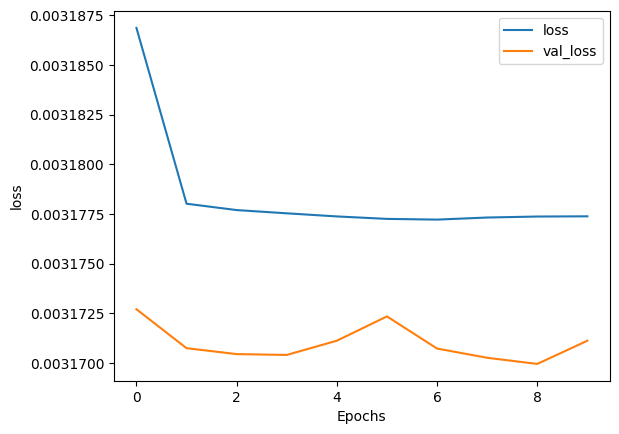

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'loss')

In [ ]:
y_pred = model_lstm.predict(y_train).squeeze()

2555/2555 [==============================] - 10s 4ms/step


In [ ]:
r2_score(y_pred,training_labels_final)

-3662870232211873.5

In [ ]:
import tensorflow.keras.backend as K

def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:

# Model Definition with LSTM
model_lr = tf.keras.Sequential([
    tf.keras.layers.Dense(40, activation='relu', input_shape=[2500]),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Set the training parameters
model_lr.compile(loss='mean_squared_error',optimizer='sgd',metrics=[r2])

# Print the model summary
model_lr.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 40)                100040    
                                                                 
 dense_19 (Dense)            (None, 20)                820       
                                                                 
 dense_20 (Dense)            (None, 1)                 21        
                                                                 
Total params: 100,881
Trainable params: 100,881
Non-trainable params: 0
_________________________________________________________________


In [ ]:
NUM_EPOCHS = 20
BATCH_SIZE = 128

# Train the model
history_lr = model_lr.fit(X_train, 
                            training_labels_final, 
                            batch_size=BATCH_SIZE, 
                            epochs=NUM_EPOCHS, 
                            validation_data=(X_test, testing_labels_final))

Epoch 1/20
639/639 [==============================] - 6s 8ms/step - loss: 0.0033 - r2_score: -0.0546 - val_loss: 0.0033 - val_r2_score: -0.0482
Epoch 2/20
639/639 [==============================] - 4s 6ms/step - loss: 0.0033 - r2_score: -0.0402 - val_loss: 0.0033 - val_r2_score: -0.0353
Epoch 3/20
639/639 [==============================] - 4s 6ms/step - loss: 0.0032 - r2_score: -0.0301 - val_loss: 0.0032 - val_r2_score: -0.0267
Epoch 4/20
639/639 [==============================] - 5s 8ms/step - loss: 0.0032 - r2_score: -0.0231 - val_loss: 0.0032 - val_r2_score: -0.0202
Epoch 5/20
639/639 [==============================] - 4s 6ms/step - loss: 0.0032 - r2_score: -0.0191 - val_loss: 0.0032 - val_r2_score: -0.0171
Epoch 6/20
639/639 [==============================] - 4s 6ms/step - loss: 0.0032 - r2_score: -0.0168 - val_loss: 0.0032 - val_r2_score: -0.0154
Epoch 7/20
639/639 [==============================] - 5s 7ms/step - loss: 0.0032 - r2_score: -0.0163 - val_loss: 0.0032 - val_r2_score: 

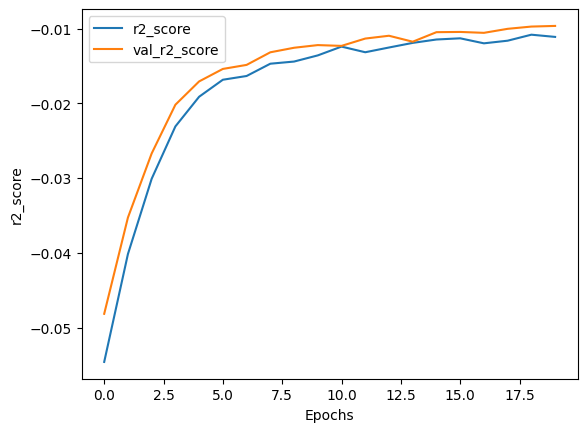

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history_lr, 'r2')

In [ ]:
y_train_pred = model_lr.predict(X_train).squeeze()

2555/2555 [==============================] - 5s 2ms/step


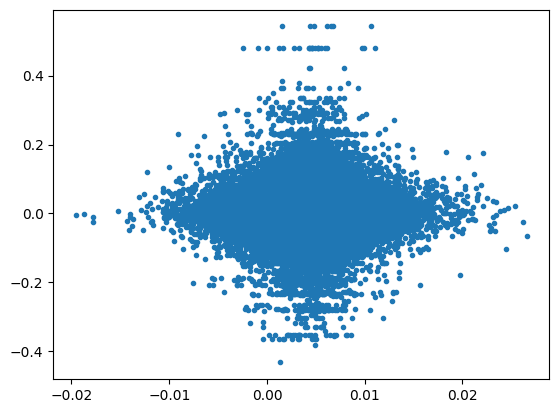

In [ ]:
plt.plot(y_train_pred,y_train,'.');